In [1]:
import torch
import torch.nn as nn
from network import *
from data import *
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import math
from mpl_finance import candlestick_ohlc

continuous_columns = ['Open', 'High', 'Low', 'Close']
discrete_columns = ['Hour', 'Day', 'Month']
target_columns = ['Close']

print("Loading : ")
btc_data = load_data(['2018', '2019'], 'BTCUSDT', continuous_columns, '5m')
btc_test_data = load_data(['2020'], 'BTCUSDT', continuous_columns, interval = '5m')

C:\Users\lmacl\Anaconda3\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


Loading : 
done
done


In [2]:
#input data shape
n_variables_past_continuous = 4
n_variables_future_continuous = 0
n_variables_past_discrete = [24]#, 31, 12]
n_variables_future_discrete = [24]#, 31, 12]

n_variables_static_discrete = [10]

#hyperparams
batch_size = 160
test_batch_size = 160
n_tests = 25
dim_model = 140
n_lstm_layers = 4
n_attention_layers = 3
n_heads = 6

quantiles = torch.tensor([0.1, 0.5, 0.9]).float().type(torch.cuda.FloatTensor)

past_seq_len = 80
future_seq_len = 15

load_model = False
path = "model_47200.pt"

#initialise
t = TFN(n_variables_past_continuous, n_variables_future_continuous, 
            n_variables_past_discrete, n_variables_future_discrete, n_variables_static_discrete, dim_model,
            n_quantiles = quantiles.shape[0], dropout_r = 0.2,
            n_attention_layers = n_attention_layers,n_lstm_layers = n_lstm_layers, n_heads = n_heads).cuda()
optimizer = torch.optim.Adam(t.parameters(), lr=0.0005)

#try to load from checkpoint
if load_model:
    checkpoint = torch.load(path)
    t = checkpoint['model_state']
    optimizer = checkpoint['optimizer_state']
    losses = checkpoint['losses']
    test_losses = checkpoint['test_losses']
    print("Loaded model from checkpoint")
else:    
    losses = []
    test_losses = []
    print("No checkpoint loaded, initialising model")

    
btc_gen = get_batches(btc_data, past_seq_len, 
                future_seq_len, continuous_columns, discrete_columns, 
                target_columns, batch_size = batch_size)

test_btc_gen = get_batches(btc_test_data, past_seq_len, 
            future_seq_len, continuous_columns, discrete_columns, 
            target_columns, batch_size = batch_size, norm = btc_data)

No checkpoint loaded, initialising model


<IPython.core.display.Javascript object>


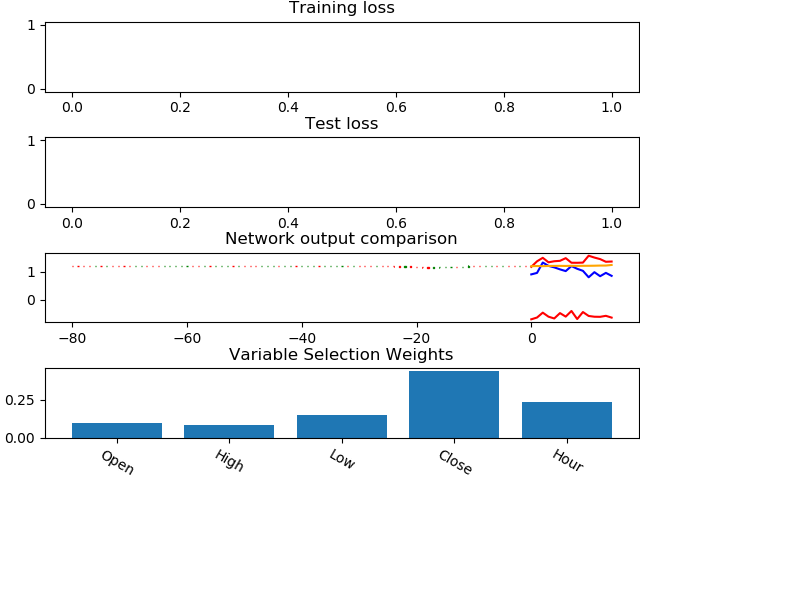

D:\OneDrive\GitHub\Temporal-Fusion-Transformer\data.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield (torch.tensor(in_seq_continuous).type(dtype).unsqueeze(-1),
D:\OneDrive\GitHub\Temporal-Fusion-Transformer\data.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(in_seq_discrete).type(dtype),
D:\OneDrive\GitHub\Temporal-Fusion-Transformer\data.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(out_seq).type(dtype),
D:\OneDrive\GitHub\Temporal-Fusion-Transformer\data.py:106: UserWarning: To copy c

KeyboardInterrupt: 

In [3]:
fig = plt.figure()
ax = fig.add_subplot(411)
ax1 = fig.add_subplot(412)
ax2 = fig.add_subplot(413)
ax3 = fig.add_subplot(414)
plt.ion()


fig.canvas.draw()
fig.show()


steps = 200000
for e in range(steps):
    #run model against test set every 50 batches
    if(len(losses) % 50 == 0 and len(losses) != 0):
        
        t.eval()
        
        m_test_losses = []
        for i in range(n_tests):
            test_loss,_ , _, _ = forward_pass(t, test_btc_gen, test_batch_size, quantiles)
            m_test_losses.append(test_loss.cpu().detach().numpy())
            
        
        test_losses.append(np.array(m_test_losses).mean())
        t.train()
        
    #save model every 400 batches
    if(len(losses) % 400 == 0 and len(losses) != 0):
        torch.save({'model_state' : t,
                    'optimizer_state': optimizer,
                   'losses' : losses, 'test_losses' : test_losses} , "model_{}.pt".format(len(losses)))
        
    #forward pass
    optimizer.zero_grad()
    loss, net_out, vs_weights, given_data = forward_pass(t, btc_gen, batch_size, quantiles)
    net_out = net_out.cpu().detach()[0]
    
    #backwards pass
    losses.append(loss.cpu().detach().numpy())
    loss.backward()
    optimizer.step()
    
    if(e % 25 == 0):
        #loss graphs
        fig.tight_layout(pad = 0.1)
        ax.clear()
        ax.title.set_text("Training loss")
        ax.plot(losses[250:])

        ax1.clear()
        ax1.title.set_text("Test loss")
        ax1.plot(test_losses[5:]) 

        #compare network out put and data
        ax2.clear()
        ax2.title.set_text("Network output comparison")
        c = given_data[0][0].cpu()
        a = torch.arange(-past_seq_len, 0).unsqueeze(-1).unsqueeze(-1).float()
        c = torch.cat((a,c), dim = 1)
        candlestick_ohlc(ax2, c.squeeze(), colorup = "green", colordown = "red")

        ax2.plot(net_out[:,0], color = "red")
        ax2.plot(net_out[:,1], color = "blue")
        ax2.plot(net_out[:,2], color = "red")
        ax2.plot(given_data[3].cpu().detach().numpy()[0], label = "target", color = "orange")

        #visualise variable selection weights
        vs_weights = torch.mean(torch.mean(vs_weights, dim = 0), dim = 0).squeeze()
        vs_weights = vs_weights.cpu().detach().numpy()
        ax3.clear()
        ax3.title.set_text("Variable Selection Weights")
        plt.xticks(rotation=-30)
        x = ['Open', 'High', 'Low', 'Close', 'Hour']
        ax3.bar(x = x, height = vs_weights)
        fig.canvas.draw()
    
    del loss
    del net_out
    del vs_weights
    del given_data


<IPython.core.display.Javascript object>


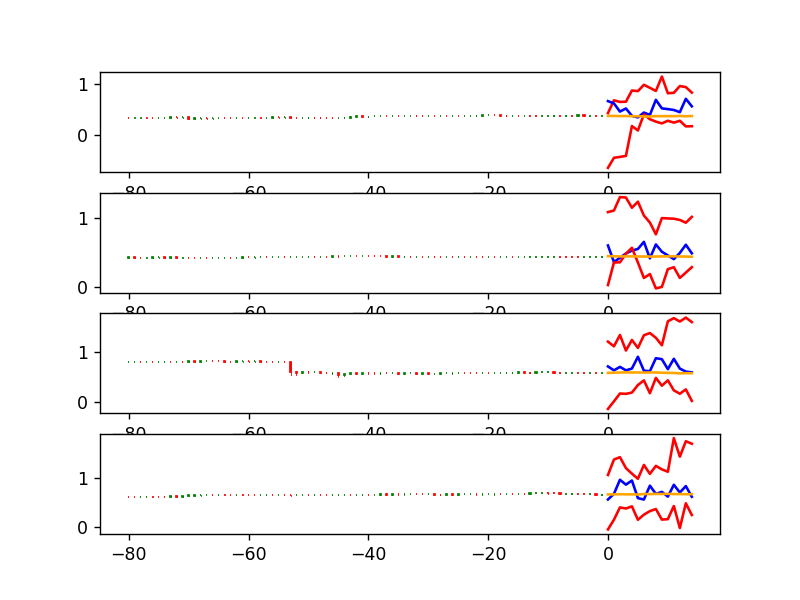

In [4]:
#Draw test cases
fig = plt.figure()
axes = []
batch_size_ = 4

for i in range(batch_size_):
    axes.append(fig.add_subplot(411 + i))
    
test_btc_gen = get_batches(btc_test_data, past_seq_len, 
            future_seq_len, continuous_columns, discrete_columns, 
            target_columns, batch_size = batch_size_, norm = btc_data)

loss, net_out, vs_weights, given_data = forward_pass(t, test_btc_gen, batch_size_, quantiles)
net_out = net_out.cpu().detach()
t.eval()
for idx, a in enumerate(axes):
    a.clear()
    
    c = given_data[0][idx].cpu()
    
    b = torch.arange(-past_seq_len, 0).unsqueeze(-1).unsqueeze(-1).float()
    c = torch.cat((b,c), dim = 1)
    candlestick_ohlc(a, c.squeeze(), colorup = "green", colordown = "red")
    
    a.plot(net_out[idx][:,0], color = "red")
    a.plot(net_out[idx][:,1], color = "blue")
    a.plot(net_out[idx][:,2], color = "red")
    a.plot(given_data[3].cpu().detach().numpy()[idx], label = "target", color = "orange")

t.train()    
plt.ion()

fig.show()
fig.canvas.draw()

In [ ]:
t = torch.rand(5,5)
z = torch.rand(5,6)
torch.cat((z, t), dim = -1).shape

In [ ]:
t = t.repeat([1,5])#.shape

In [ ]:
t